In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from analysis_functions.basic_data_inspection import *
from analysis_functions.missing_values_analysis import *

from analysis_functions.univariate_analysis import *
from analysis_functions.bivariate_analysis import *
from analysis_functions.multivariate_analysis import *

from processing_functions.outlier_detection import *
from processing_functions.handle_missing_values import *

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor
import lightgbm as lgb

In [99]:
warnings.filterwarnings("ignore")

LOAD DATA

In [100]:
df = pd.read_csv("Airbnb_Data.csv")
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


CHECK NULL VALUES AND THE DATATYPE OF EACH COLUMNS

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

GET RID OF THE REDUNDANT COLUMNS

In [102]:
df.drop(columns=["id","name","description","thumbnail_url","neighbourhood","zipcode"], axis=1, inplace=True)

CONVERT "host_since", "first_review", "last_review" INTO DATETIME

In [103]:
df["host_since"] = pd.to_datetime(df["host_since"], errors="coerce")
df["first_review"] = pd.to_datetime(df["first_review"], errors="coerce")
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   log_price               74111 non-null  float64       
 1   property_type           74111 non-null  object        
 2   room_type               74111 non-null  object        
 3   amenities               74111 non-null  object        
 4   accommodates            74111 non-null  int64         
 5   bathrooms               73911 non-null  float64       
 6   bed_type                74111 non-null  object        
 7   cancellation_policy     74111 non-null  object        
 8   cleaning_fee            74111 non-null  bool          
 9   city                    74111 non-null  object        
 10  first_review            58247 non-null  datetime64[ns]
 11  host_has_profile_pic    73923 non-null  object        
 12  host_identity_verified  73923 non-null  object

USE SimpleMissingValuesAnalysis() TO SEE THE NUMBER OF NULL VALUES IN EACH COLUMNS AND VISUALIZE IT


Missing Values Count by Column:
bathrooms                   200
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
last_review               15827
review_scores_rating      16722
bedrooms                     91
beds                        131
dtype: int64

Visualizing Missing Values...


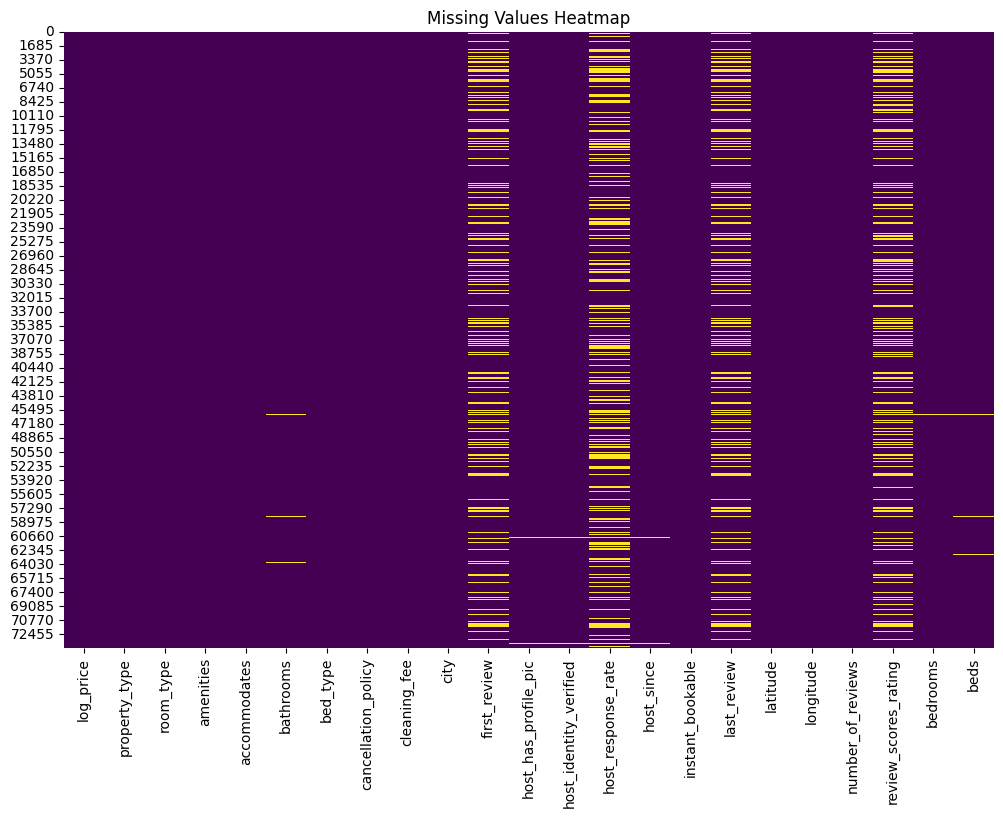

In [105]:
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(df)

In [106]:
#Handle missing values in "bathrooms", "bedrooms", "beds" columns
cols = ["bathrooms", "bedrooms", "beds"]

#Using the median method to fill the missing values
missing_value_handler = MissingValueHandler(FillMissingValuesStrategy(method="median"))
df[cols] = missing_value_handler.handle_missing_values(df[cols])

2025-12-15 01:11:40,298 - INFO - Executing missing value handling strategy.
2025-12-15 01:11:40,300 - INFO - Filling missing values using method: median
2025-12-15 01:11:40,309 - INFO - Missing values filled.


In [107]:
#Handle missing values "review_scores_rating"
#Calculate the median values of "review_scores_rating"
#Only from the listing has number_of_reviews > 0
fill_with_median_value = df.loc[
    df["number_of_reviews"] > 0,
    "review_scores_rating"
].median()


#Create mask's condition (boolean mask)
has_reviews = df["number_of_reviews"] > 0
no_reviews = df["number_of_reviews"] == 0


#With listing has review > 0 -> Fill missing values of "review_scores_rating" by using median
df.loc[has_reviews, "review_scores_rating"] = (
    df.loc[has_reviews, "review_scores_rating"]
      .fillna(fill_with_median_value)
)


#With listing has no review(review = 0) -> Fill review_scores_rating = -1 (-1 = has no rating)
df.loc[no_reviews, "review_scores_rating"] = (
    df.loc[no_reviews, "review_scores_rating"]
      .fillna(-1)
)

In [108]:
#Calculate the number of days from "host_since", "first_review", "last_review" to the current day
df["host_since"] = (pd.to_datetime('today') - df["host_since"]).dt.days
df["first_review"] = (pd.to_datetime('today') - df["first_review"]).dt.days
df["last_review"] = (pd.to_datetime('today') - df["last_review"]).dt.days

In [109]:
#Handle missing values for "host_since" "first_review" "last_review" columns
#The date that never happened -> Fill with -1
day_cols = ["host_since", "first_review", "last_review"]
df[day_cols] = df[day_cols].fillna(-1)

In [110]:
#Get rid of "%" and convert the values in "host_response_rate" into numerical
df["host_response_rate"] = df["host_response_rate"].str.rstrip("%").astype(float)/100.0

In [111]:
#Fill missing values for "host_response_rate"
#When "host_response_rate" columns has no data -> Fill = -1
df["host_response_rate"] = df["host_response_rate"].fillna(-1)

In [112]:
#Fill missing values for "host_has_profile_pic", "host_identity_verified"
#Using constant method with fill_value = unknow
cols = ["host_has_profile_pic", "host_identity_verified"]

missing_value_handler = MissingValueHandler(FillMissingValuesStrategy(method="constant", fill_value="unknow"))
df[cols] = missing_value_handler.handle_missing_values(df[cols])

2025-12-15 01:11:40,503 - INFO - Executing missing value handling strategy.
2025-12-15 01:11:40,504 - INFO - Filling missing values using method: constant
2025-12-15 01:11:40,512 - INFO - Missing values filled.



Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


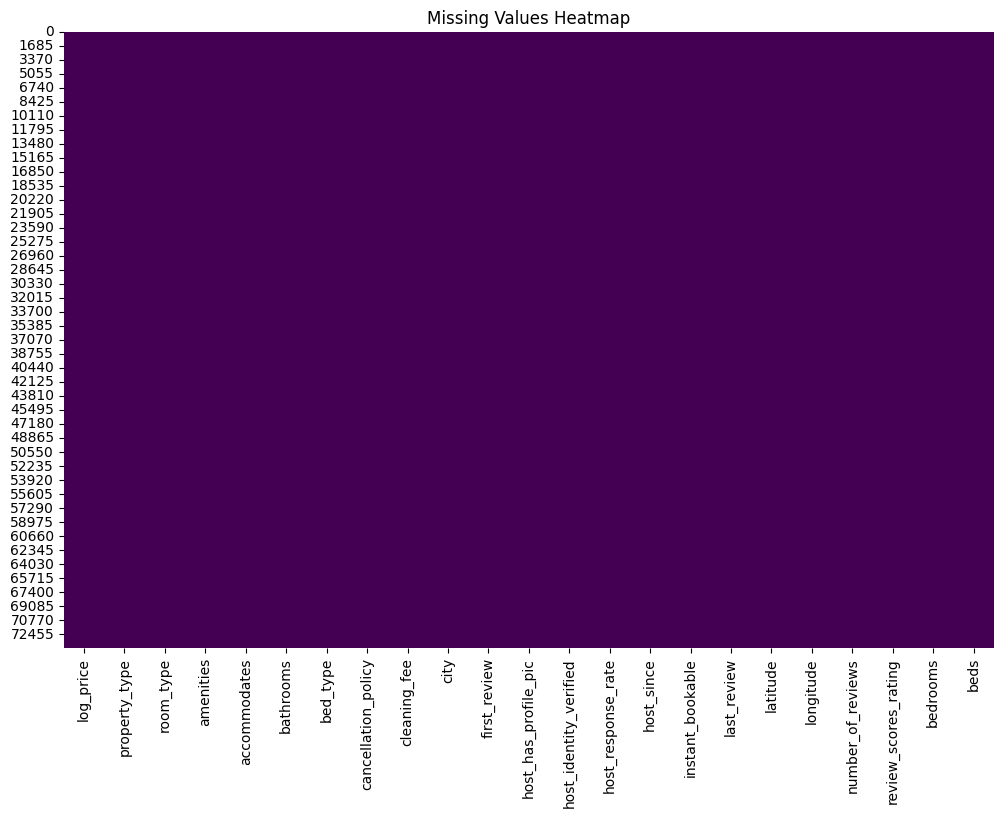

In [113]:
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(df)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               74111 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  first_review            74111 non-null  float64
 11  host_has_profile_pic    74111 non-null  object 
 12  host_identity_verified  74111 non-null  object 
 13  host_response_rate      74111 non-null  float64
 14  host_since              74111 non-null

In [115]:
#Seperate and count the number of "amenities"
df["amenities"] = df["amenities"].apply(lambda x: len(x.strip('{}').split(',')))

OUTLIERS DETECTED

2025-12-15 01:11:42,252 - INFO - Executing outlier detection strategy.
2025-12-15 01:11:42,253 - INFO - Detecting outliers using the IQR method.
2025-12-15 01:11:42,279 - INFO - Outliers detected using the IQR method.
2025-12-15 01:11:42,281 - INFO - Visualizing outliers for features: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'host_since', 'first_review', 'last_review']


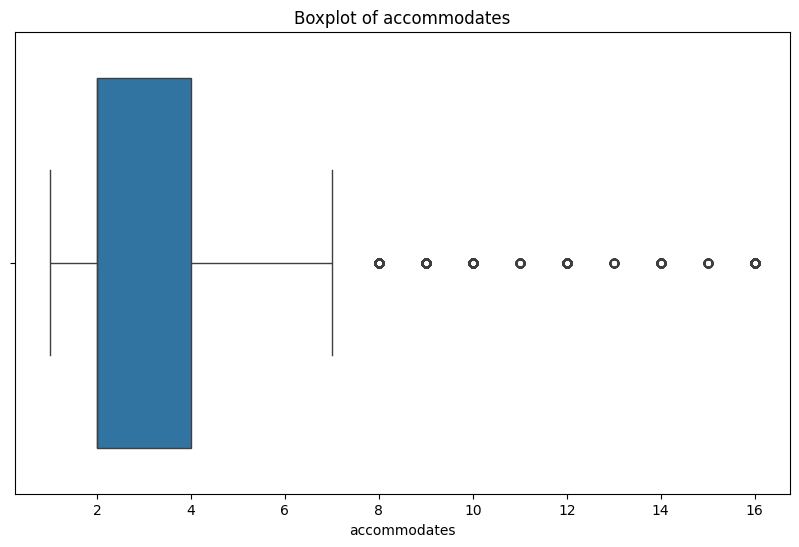

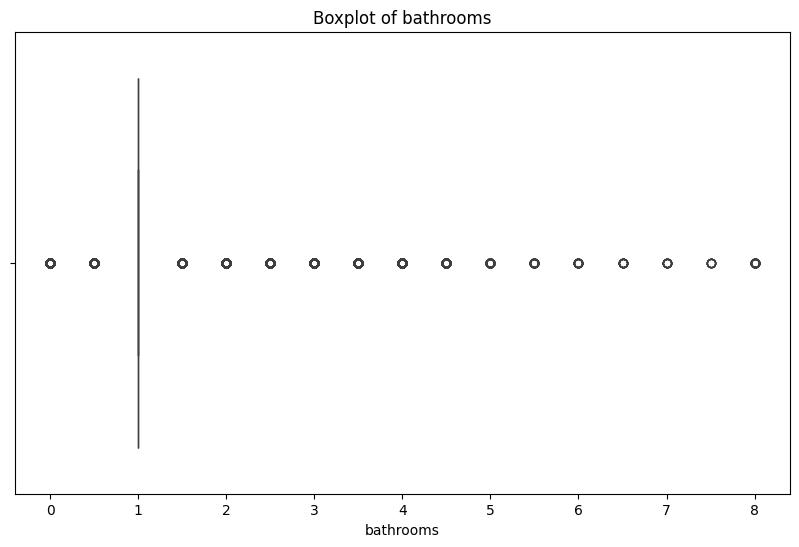

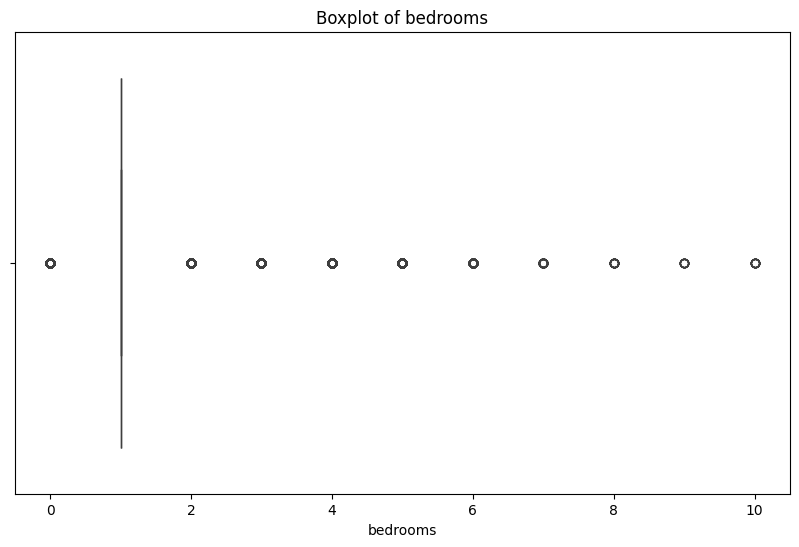

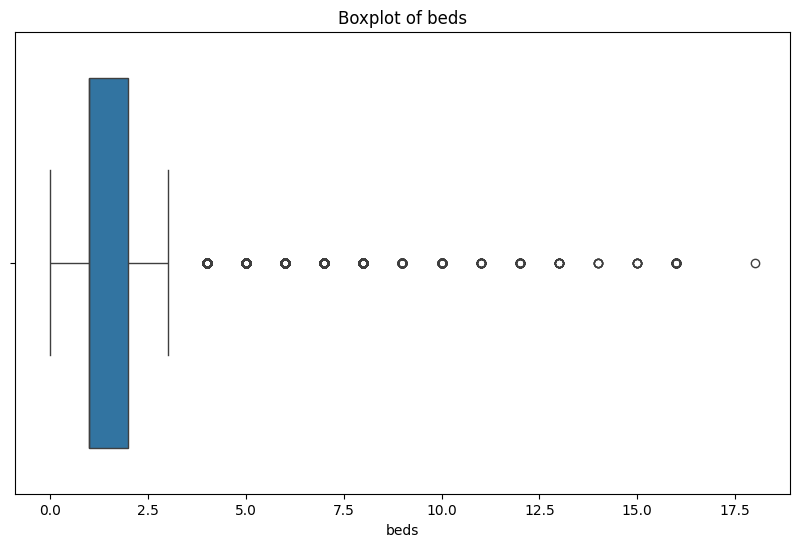

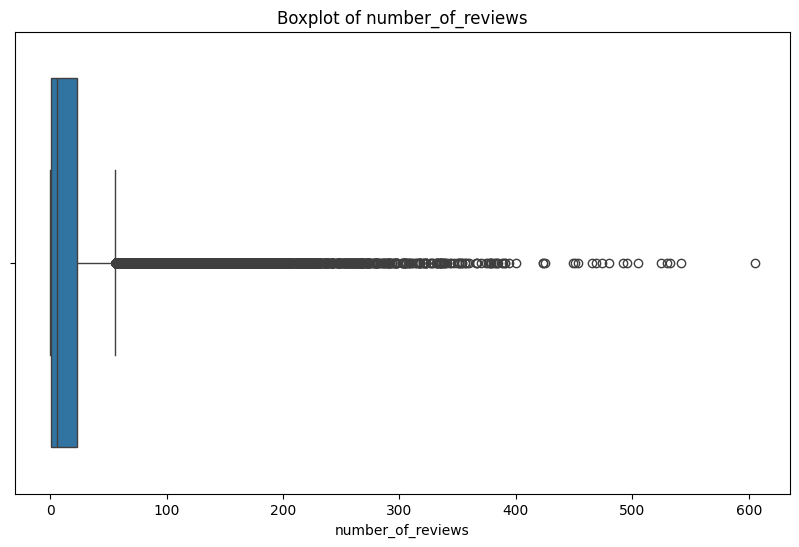

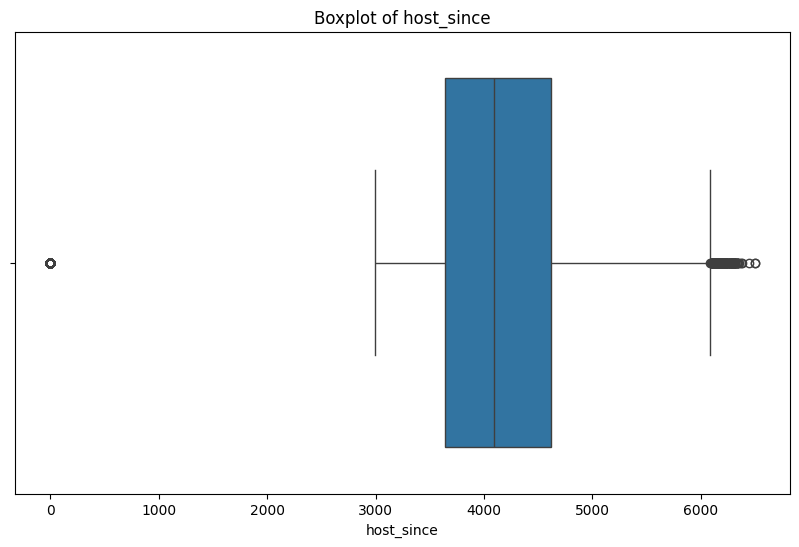

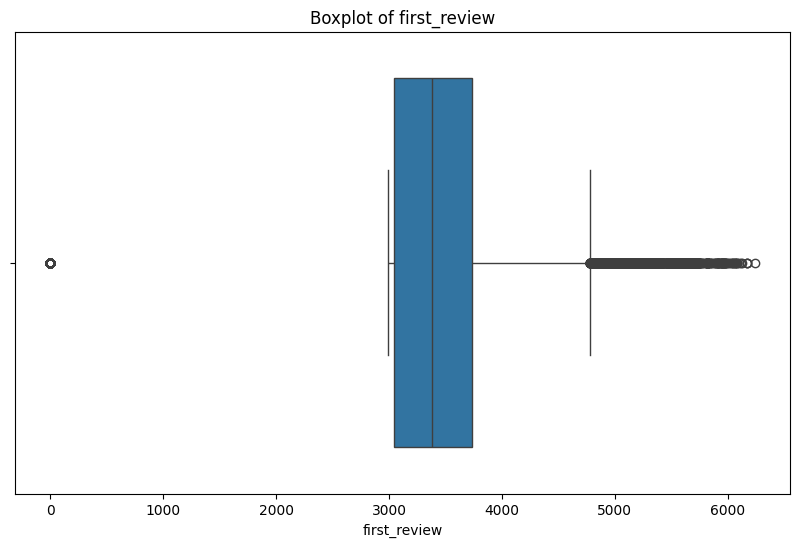

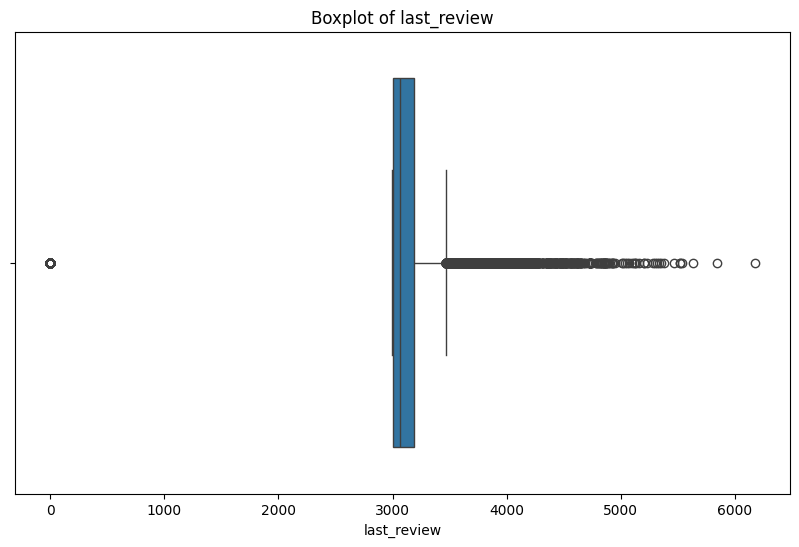

2025-12-15 01:11:43,548 - INFO - Outlier visualization completed.


In [116]:
#Using OutlierDetector => IQROutlierDetection()
cols = ["accommodates", "bathrooms", "bedrooms", "beds", "number_of_reviews", "host_since", "first_review", "last_review"]

outlier_detector = OutlierDetector(IQROutlierDetection())

outliers = outlier_detector.detect_outliers(df, cols)
outlier_detector.visualize_outliers(df, features=cols)

In [117]:
#Defining input và output feature
X = df.drop("log_price", axis=1)
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [118]:
#Defining the categorical columns that are needed for ML models
categorical_cols = ["property_type", "room_type", "amenities", "bed_type", "cancellation_policy", "cleaning_fee", "city", "host_has_profile_pic", "host_identity_verified", "instant_bookable"]

#Defining the numerical columns that are needed to scale
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [119]:
#Defining ColumnTransformer to handle categorical và numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

In [120]:
#Defining the ML models
models = {
    "LinearRegression" : LinearRegression(),
    "DecisionTree" : DecisionTreeRegressor(random_state=42),
    "RandomForest" : RandomForestRegressor(random_state=42),
    "GradientBoosting" : GradientBoostingRegressor(random_state=42),
    "XGBoost" : XGBRegressor(random_state=42),
    "LightGBM" : lgb.LGBMRegressor(random_state=42, verbose=-1)
}

In [121]:
#Declare the ML models with params
param_grids = {
    "LinearRegression": {},
    "DecisionTree": {"estimator__max_depth": [None, 10, 20], "estimator__min_samples_split": [2, 5, 10]},
    "RandomForest": {"estimator__n_estimators": [50, 100, 200], "estimator__max_depth": [5, 10, 20]},
    "GradientBoosting": {"estimator__n_estimators": [50, 100, 200], "estimator__learning_rate": [0.05, 0.1, 0.2]},
    "XGBoost": {"estimator__n_estimators": [50, 100, 200], "estimator__learning_rate": [0.05, 0.1, 0.2]},
    "LightGBM": {"estimator__n_estimators": [50, 100, 200], "estimator__learning_rate": [0.05, 0.1, 0.2]}
}

grid_result={}

for name, model in models.items():
  print(f"Running GridSearchCV for {name}")

  pipe = Pipeline(
      steps = [
          ("preprocessor", preprocessor),
          ("estimator", model)
      ]
  )

  grid=GridSearchCV(pipe, param_grids[name], cv=3, scoring="r2", n_jobs=-1, verbose=1)
  grid.fit(X_train, y_train)

  grid_result[name]={
      "best_param": grid.best_params_,
      "best_cv_r2": grid.best_score_
  }

  best_model= grid.best_estimator_
  y_pred = best_model.predict(X_test)

  mae = metrics.mean_absolute_error(y_test, y_pred)
  mse = metrics.mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = metrics.r2_score(y_test, y_pred)

  grid_result[name]["test_metrics"] = {"MAE": mae , "MSE": mse, "RMSE": rmse, "R2": r2}

  print(f"Best params for {name} : {grid.best_params_}")
  print(f"Best CV R2: {grid.best_score_:.2f}")
  print(f"Test R2: {r2:.2f}")

print("Tóm tắt GridSearchCV")
for name, res in grid_result.items():
  print(f"{name}: Best CV R2 = {res['best_cv_r2']:.4f}, Test R2 = {res['test_metrics']['R2']:.4f}")

Running GridSearchCV for LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params for LinearRegression : {}
Best CV R2: 0.55
Test R2: 0.55
Running GridSearchCV for DecisionTree
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params for DecisionTree : {'estimator__max_depth': 10, 'estimator__min_samples_split': 10}
Best CV R2: 0.62
Test R2: 0.64
Running GridSearchCV for RandomForest
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params for RandomForest : {'estimator__max_depth': 20, 'estimator__n_estimators': 200}
Best CV R2: 0.70
Test R2: 0.71
Running GridSearchCV for GradientBoosting
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params for GradientBoosting : {'estimator__learning_rate': 0.2, 'estimator__n_estimators': 200}
Best CV R2: 0.70
Test R2: 0.71
Running GridSearchCV for XGBoost
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params for XGBoost : {'estimator__learning_rate': 0.

WHAT-IF ANALYSIS

In [122]:
#Set scripted to test the potential of Suggestion
WHAT_IFS = (
    ("Increased accommodates to 6", {"accommodates": 6}),
    ("Increased bathroom to 2", {"bathrooms": 2.0}),
    ("Cleaning_fee is free", {"cleaning_fee": False})
)

In [123]:
base_log_price = best_model.predict(df.iloc[[0]])[0]
base_price = np.exp(base_log_price)

In [124]:
rows = []

for desc, change in WHAT_IFS:
  scenario = df.iloc[[0]].copy()

  for k, v in change.items():
    scenario[k] = v

  p_log = best_model.predict(scenario)[0]
  p = np.exp(p_log)

  rows.append([desc, round(p - base_price, 2)])

output_df = pd.DataFrame(rows, columns=["Scripted" , "Difference compared to the base price"])
output_df

,Scripted,Difference compared to the base price
0,Increased accommodates to 6,63.74
1,Increased bathroom to 2,25.19
2,Cleaning_fee is free,-6.93


INSIGHTS

#Increasing accommodates to 6 leads to the largest price uplift (+63.74), indicating that guest capacity is a primary driver of listing value.

#Increasing the number of bathrooms to 2 also has a positive impact on price (+25.19), suggesting that comfort and convenience features significantly influence pricing.

#Offering free cleaning slightly reduces the predicted price (−6.93), implying that cleaning fees are generally accepted by the market and do not strongly deter pricing potential.